# Transposée de matrice et défauts de cache

*Billet et travail réalisés à plusieurs mains. Merci à Xavier J. et Ludomir O. pour les explications et relectures.*

J'ai reçu récemment un mail d'un ami qui me rapportait des problèmes de temps de calcul autour des produits matriciels de `numpy` et de `scipy.linalg.blas`. Après avoir replongé dans les bases de l'architecture de l'ordinateur, nous avons analysé le problème de la transposée de matrice du point de vue de l'utilisation des différents niveaux de cache.

La version exécutable (complète) de cette page est également disponible [ici](https://github.com/xoolive/xoolive.github.io/raw/master/notebooks/2016-04-15-cache-miss-matrix-transposition.ipynb) afin de permettre à ceux qui le souhaitent de comparer les performances présentées avec d'autres architectures.

### Préliminaires

In [1]:
%matplotlib inline

# Mesure de performance
import time

# Tableaux & matrices
import numpy as np

# Affichage de graphes et palette de couleur décente
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='Set2')
sns.despine()

In [2]:
# Style cohérent pour tous nos rendus graphiques
def add_info(title, xscale='log', yscale='linear',
             xlim=(32, 2052), ylim=None,
             ticks=[i for i in range(5, 12)] + [9 + np.log2(3)]):
    ax = plt.gca()
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xticks([int(2 ** i) for i in ticks])
    ax.set_xticklabels([int(2 ** i) for i in ticks])
    ax.set_ylabel("time (ns)")
    ax.set_xlabel("matrix size")
    ax.set_title(title)

In [3]:
def chrono(n):
    def chrono_time(func):
        def func_wrapper(*args, **kwargs):
            t = time.time()
            for i in range(n):
                func(*args, **kwargs)
            t = time.time() - t
            return t/n
        return func_wrapper
    return chrono_time

In [4]:
%load_ext Cython

## Organisation de la mémoire

### Registres, caches L1, L2, L3

Le principe général de l'organisation de la mémoire d'un ordinateur se base sur le fait que plus la mémoire est située proche du processeur, plus les temps d'accès sont rapides. En revanche, la proximité vient au prix de l'espace physique accordé à cette mémoire, et par conséquent de la taille mémoire disponible.

Une solution économique pour répondre au besoin des développeurs qui souhaitent une quantité illimitée de mémoire rapide est l'organisation en différents niveaux de mémoire : on place des registres très rapides au plus près des processeurs, puis des caches (L1, L2, voire L3) de plus en plus grands et de plus en plus éloignés du processeur. Ensuite vient la mémoire vive (RAM) séparée du processeur par un bus mémoire, puis la mémoire système (le disque dur) accessible pour la RAM via un bus I/O.

Lorsque le processeur cherche une donnée en mémoire, il la recherche d'abord dans les registres, puis dans les différents niveaux de cache, puis en RAM, voire sur le disque dur. Chaque recherche dans le niveau supérieur induit un temps de latence dont l'ordre de grandeur est donné dans le tableau ci-dessous. On spécifie également la taille de chacun de ces éléments sur une machine équipée de quatre processeurs Intel® Core™ i7-640M.

|             | Registres | Cache L1 | Cache L2 | Cache L3 | RAM   | Disque |
|:-----------:|:---------:|:--------:|:--------:|:--------:|:-----:|:------:|
| **taille**  | 1 KB      | 32 KB    | 512 KB   | 4 MB     | 8 GB  | 2 TB   |
| **vitesse** | 300 ps    | 1 ns     | 3 ns     | 10 ns    | 60 ns | 10 ms  |

Pour des raisons de performance, les données sont déplacées entre niveaux de mémoire par blocs de 64 octets. Si le processeur demande un flottant double-précision (8 octets), un bloc de 64 octets contenant le flottant est recopié depuis la RAM dans le cache L3, puis du cache L3 dans le L2, puis du L2 dans le L1, pour finalement être recopié dans les registres.

Cette stratégie peut s'avérer payante lors de la manipulation de tableaux dont les données sont contiguës en mémoire. Si le processeur demande l'accès à un élément `a[i]`, au moins un flottant parmi `a[i-1]` et `a[i+1]` est également recopié dans le niveau de cache inférieur.

Lorsque le processeur ne trouve pas les données demandées en cache, et qu'il les réclame au niveau supérieur, on parle de *défaut de cache* (*cache miss*). Les défauts de cache se répartissent en trois catégories (les 3 C) :

- *compulsory* : le bloc mémoire n'a jamais été chargé auparavant,
- *capacity* : un bloc mémoire est vidé du cache pour être récupéré à nouveau plus tard, et
- *conflict*, dans les caches associatifs (voir ci-dessous).

Au vu des temps de latence indiqués ci-dessus, la pénalité induite par un défaut systématique de cache L2 est de 10 ns, soit le coût d'un accès au cache L3. Si 50% des accès au cache L2 entraînent un défaut de cache, alors la pénalité moyenne n'est plus que de 5 ns. Il est donc important de réduire au maximum la probabilité de défaut de cache.

Différentes stratégies (Hennessy & Patterson en mentionnent onze) existent pour pallier le surcoût induit par les défauts de cache, que ce soit au niveau *hardware* (matériel) ou *software* (logiciel). Les compilateurs sont capables d'optimiser un code pour réduire les défauts de cache lors de son exécution.

### Associativité du cache

L'associativité est un trait de conception des caches qui propose un compromis entre rapidité d'accès aux données et réduction de la probabilité de défaut de cache. On présente souvent la métaphore du parking d'une grande entreprise pour expliquer le fonctionnement d'un cache associatif.

On peut envisager plusieurs stratégies pour que chaque employé trouve une place où se garer le matin :

1. Chaque place du parking est attribuée à un employé et tous les employés se garent toujours au même endroit. Beaucoup de places peuvent rester vides en fonction des missions à l'extérieur, des congés, etc.
2. Tous les employés peuvent se garer librement. Les plus lève-tard doivent alors errer dans le parking à la recherche d'une place libre.

Une troisième stratégie consiste à découper le parking en zones attribuées à un groupe d'employés : la recherche de place libre est alors limitée à la zone attribuée à l'employé (bien plus petite que le parking), sans que chaque place soit nominative.

De la même manière, un cache *K-way associative* est organisé en N ensembles de K blocs, où chaque bloc a une capacité de L octets. Sur Intel® Core™ i7-640M, le cache L1 de 32 KB est *4-way associative*, le cache L2 de 512 KB est *8-way associative* et le cache L3 de 4 MB est *16-way associative*.

Ainsi, le cache L2 est défini par le triplet K=8, L=64, N=1024 (soit un total de 512KB). Un bloc situé à une adresse mémoire donnée peut alors être copié dans un bloc parmi K=8 sur le cache L2. Un calcul de l'adresse mémoire modulo N=1024 donne l'emplacement qui contient le bloc mémoire donné.

Illustrons à présent le parcours d'un tableau de 8204 flottants double précision (en C, `double a[8204]`). Sans perte de généralité, on suppose que l'adresse du début du tableau correspond à un début de bloc mémoire. L'appel à `a[0]` entraîne un défaut de cache puis la copie du bloc mémoire qui contient `a[0]` mais aussi `a[1], a[2], ... a[7]` vers un bloc de l'emplacement `p = a % 1024`. Les appels suivants à `a[1], ... a[7]` n'entraînent aucun défaut de cache. L'appel à `a[8]` appelle la copie du bloc mémoire contenant `a[8], a[9], ... a[15]` vers l'emplacement `(p+1) % 1024`.

Lors de l'appel à `a[8196]`, le bloc mémoire contenant `a[8196], a[8197], ... a[8203]` est copié vers l'emplacement `(p+1024) % 1024`, soit le même emplacement que `a[0], ... a[7]`. Cet emplacement peut toutefois contenir K=8 blocs. Si un des autres blocs est libre, on peut copier le nouveau bloc mémoire. Sinon, il faut choisir un bloc à effacer pour laisser la place à `a[8196], ... a[8203]`. Suivant la stratégie de remplacement choisie, on peut être amené à effacer le bloc `a[0], ... a[7]` ce qui entraînera un défaut de cache de type *conflict*.

## Transposition de matrices

In [5]:
%%cython

cimport numpy as cnp
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int c_transpose(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b) nogil:
    cdef int i = 0, j = 0
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    # Parcours en i, j
    for i in range(maxi):
        for j in range(maxj):
            b[j, i] = a[i, j]
    # Renvoi d'un type compatible Python pour le cpdef
    return 0

La transposée $B$ d'une matrice $A$ de dimension $n \times n$ est définie par la relation $\forall i, j \quad b_{j, i} = a_{i, j}$.

Les deux matrices sont stockées de manière contiguë en mémoire. Les indices sont linéarisés en $i \cdot n + j$. En faisant varier $i$ puis $j$, le parcours de $A$ est linéaire et le fonctionnement du cache est conforme à la description ci-dessus.

En revanche, le parcours de $B$ se fait en $j \cdot n + i$ par saut de $n$ pour chaque incrément de $j$.

Comparons alors cette fonction de transposition compilée avec différentes options. Pour se rapprocher au plus près du coût de la transposition d'un élément :

- les opérations sont codées en C, via Cython et le mécanisme de [*typed memoryviews*](http://docs.cython.org/src/userguide/memoryviews.html) de `numpy` ;
- les temps d'exécution ne sont mesurés que sur la partie « transfert de données » (sans mesurer l'allocation de mémoire) ;
- les temps d'exécution sont rapportés au transfert d'un élément $i, j$ vers $j, i$ (division par $n^2$)

In [6]:
def time_transpose(transpose, n):
    # Allocation d'une matrice et de sa transposée
    a = np.empty((n, n), dtype=float)
    b = np.empty((n, n), dtype=float)
    # On rapporte le temps d'exécution à un transfert unitaire
    return transpose(a, b) / (n**2) * 1e9 # en nanosecondes

def benchmark_transpose(fun_arg, params):
    interval, times = [], []
    for p in params:
        for i in p['interval']:
            interval.append(i)
            t = time_transpose(chrono(p['repeat'])(fun_arg), i)
            times.append(t)
    return (np.array(interval), np.array(times))

On nomme différentes versions de la même fonction en référence aux options de compilation:

- `c_transpose_o0` pour une compilation avec l'option `-O0` pour empêcher toute optimisation ;

- `c_transpose_o2` pour une compilation avec l'option `-O2` pour les optimisations les plus raisonnables ;

- `c_transpose_fast` pour l'option `-Ofast -march=native` qui réclame au compilateur toutes les optimisations, notamment :
    - les plus agressives ; et
    - les plus spécifiques à notre architecture.

In [7]:
%%cython --compile-args=-O0

cimport numpy as cnp
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int c_transpose_o0(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b) nogil:
    cdef int i = 0, j = 0
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    # Parcours en i, j
    for i in range(maxi):
        for j in range(maxj):
            b[j, i] = a[i, j]
    # Renvoi d'un type compatible Python pour le cpdef
    return 0

In [8]:
%%cython --compile-args=-O2

cimport numpy as cnp
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int c_transpose_o2(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b) nogil:
    cdef int i = 0, j = 0
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    # Parcours en i, j
    for i in range(maxi):
        for j in range(maxj):
            b[j, i] = a[i, j]
    # Renvoi d'un type compatible Python pour le cpdef
    return 0

In [9]:
%%cython --compile-args=-Ofast --compile-args=-march=native

cimport numpy as cnp
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int c_transpose_fast(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b) nogil:
    cdef int i = 0, j = 0
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    # Parcours en i, j
    for i in range(maxi):
        for j in range(maxj):
            b[j, i] = a[i, j]
    # Renvoi d'un type compatible Python pour le cpdef
    return 0

In [12]:
params = [{'interval': range(2, 512), 'repeat': 10},
          {'interval': range(512, 1024, 2), 'repeat': 5},
          {'interval': range(1024, 2048, 4), 'repeat': 1},
         ]

In [13]:
interval_o0, times_o0 = benchmark_transpose(c_transpose_o0, params)

In [14]:
interval_o2, times_o2 = benchmark_transpose(c_transpose_o2, params)

In [38]:
interval_fast, times_fast = benchmark_transpose(c_transpose_fast, params)

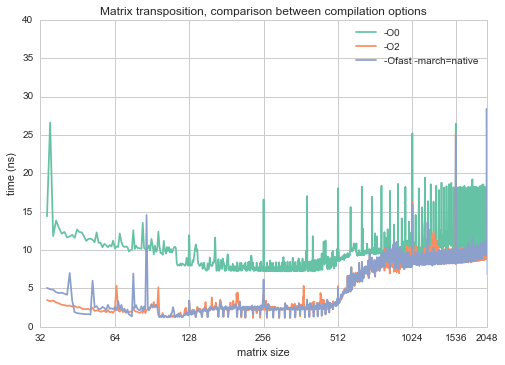

In [39]:
plt.plot(interval_o0[32:], times_o0[32:], label="-O0")
plt.plot(interval_o2[32:], times_o2[32:], label="-O2")
plt.plot(interval_fast[32:], times_fast[32:], label="-Ofast -march=native")
plt.legend(loc='best')

add_info("Matrix transposition, comparison between compilation options")

Quelles que soient les optimisations apportées par le compilateur (`-02` ou `-Ofast -march=native`) et malgré des temps d'exécution divisés par deux pour les petites tailles dans le code optimisé, on remarque des chutes de performances de l'ordre de 10 ns (plus de 100%) pour des tailles de matrices n × n, où n est une puissance de deux ou une combinaison linéaire de puissances de deux : 256 × 256, 512 × 512; 1024 × 1024, 1536 × 1536 (1024 + 512), 2048 × 2048, entre autres.

Une matrice de flottants double précision de taille $n \times n$ remplit $8\,n^2$ octets. Une matrice de taille 64 &times; 64 remplit alors 32 KB de mémoire (la taille du cache L1), une matrice de taille 256 &times; 256 remplit 512 KB de mémoire (la taille du cache L2), une matrice de taille 1024 &times; 1024 remplit 8 MB de mémoire (le double de la taille du cache L3).

Reprenons le parcours de la matrice B (le résultat de la transposée) pour une taille de 1024 &times; 1024. Lors de l'accès à `b[0, 0]`, le bloc qui contient `b[0, 0], ... b[0, 7]` est copié dans le cache L2 à l'emplacement `p`. L'accès suivant à `b[1, 0]` copie le bloc qui contient `b[1, 0], ... b[1, 7]` à l'emplacement `(p+128) % 1024`, et ainsi de suite jusqu'à `b[8, 0], ... b[8, 7]` qui sera copié à l'emplacement `(p+1024) % 1024 = p`: toute la colonne `b[i, 0]` sera donc copiée et répartie sur 8 emplacements parmi 1024; les éléments `b[i, 0]` commenceront donc à être vidés du cache au plus tard à l'accès à `b[64, 0]`.

Lors de l'accès à `b[0, 1]`, la donnée n'est plus en cache est doit être copiée à nouveau avec le bloc `b[0, 0], ... b[0, 7]` dans le cache L2 à l'emplacement `p`. Dès lors, les défauts de cache conflictuels (*conflict miss*) s'enchaînent et font s'écrouler les performances pour ce type de matrice.

Le même raisonnement s'applique dans une moindre mesure pour les matrices 512 × 512 dans une moindre mesure (16 emplacements), 256 × 256 (32 emplacements), etc.


## Transposition par blocs

On peut pallier le problème de modulo dans le cache en découpant nos matrices en sous-matrices de taille moindre (32 × 32 par exemple) et en transposant chacun de ces blocs (sous-matrices) dans l'ordre. Un bloc 32 × 32 présente l'avantage de tenir entièrement dans le cache L1 et donc d'éviter les défauts de cache conflictuels.


In [17]:
%%cython --compile-args=-Ofast --compile-args=-march=native

import numpy as np
cimport numpy as cnp
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cdef int c_transpose(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b) nogil:
    cdef int i = 0, j = 0
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    for i in range(maxi):
        for j in range(maxj):
            b[j, i] = a[i, j]
    return 0
            
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int c_transpose_block(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b, int size) nogil:
    cdef int i = 0, j = 0, i_ = 0, j_ = 0
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    # Parcours en j, i pour les blocs, en i, j à l'intérieur
    for j_ in range(maxj//size):
        j = size * j_
        for i_ in range(maxi//size):
            i = size * i_
            c_transpose(a[i:(i+size),j:(j+size)], b[j:(j+size), i:(i+size)])
        c_transpose(a[i:,j:(j+size)], b[j:(j+size), i:])
    c_transpose(a[i:,j:], b[j:, i:])
    return 0

Il nous faut alors adapter les fonctions de benchmark pour prendre en compte la taille des blocks.

In [25]:
def time_block(transpose, n, size):
    a = np.empty((n, n), dtype=float)
    b = np.empty((n, n), dtype=float)
    return transpose(a, b, size) / (n**2) * 1e9 # en ns

def benchmark_transpose_block(fun_arg, params):
    interval, times = [], []
    for p in params:
        for i in p['interval']:
            interval.append(i)
            t = time_block(chrono(p['repeat'])(fun_arg),
                           i, p['block'])
            times.append(t)
    return (np.array(interval), np.array(times))

In [26]:
params = [{'interval': range(2, 512), 'repeat': 10, 'block': 32},
          {'interval': range(512, 1024, 2), 'repeat': 5, 'block': 32},
          {'interval': range(1024, 2048, 4), 'repeat': 1, 'block': 32},
          {'interval': range(2048, 4096, 16), 'repeat': 1, 'block': 32},
          {'interval': range(4096, 8108, 32), 'repeat': 1, 'block': 32},
         ]

In [27]:
interval_32, times_32 = benchmark_transpose_block(c_transpose_block, params)

In [28]:
params64 = [{'interval': range(2, 512), 'repeat': 10, 'block': 64},
            {'interval': range(512, 1024, 2), 'repeat': 5, 'block': 64},
            {'interval': range(1024, 2048, 4), 'repeat': 1, 'block': 64},
           ]

In [29]:
interval_64, times_64 = benchmark_transpose_block(c_transpose_block, params64)

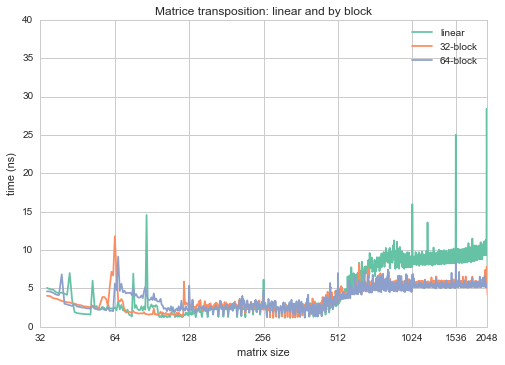

In [40]:
plt.plot(interval_fast[32:], times_fast[32:], label="linear")
plt.plot(interval_32[32:], times_32[32:], label="32-block")
plt.plot(interval_64[32:], times_64[32:], label="64-block")
plt.legend(loc="best")

add_info("Matrice transposition: linear and by block")

La stratégie d'une transposition par bloc n'est pas forcément très pertinente pour les tailles de matrice, mais :

- les chutes de performance pour les matrices 1024 × 1024, 1536 × 1536, 2048 × 2048 disparaissent ;
- les temps d'exécution pour les grandes matrices sont divisés par deux.

On constate néanmoins une chute de performance pour des tailles de matrice immédiatement supérieures à la taille d'un bloc (32 × 32 ou 64 × 64) ; cette chute est néanmoins rattrapée rapidement au fur et à mesure que la matrice grandit.

## Écriture directe sans passer par les caches

Les compilateurs Intel livrés avec le jeu d'instructions SSE2 exposent un ensemble de méthodes pour écrire directement en mémoire RAM sans polluer les caches. On y trouve notamment l'instruction `_mm_stream_si64` pour l'écriture d'un entier 64 bits (la même taille qu'un flottant double précision).

Il reste impossible d'éviter les caches à la lecture de données.

In [31]:
%%cython --compile-args=-Ofast --compile-args=-march=native

import numpy as np
cimport numpy as cnp
cimport cython

cdef extern from "emmintrin.h" nogil:
    void _mm_stream_si64(long long *, long long)

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int c_transpose_bypass(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b) nogil:
    cdef int i = 0, j = 0
    cdef long long a1
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    cdef long long* pta = <long long*> (&a[0, 0])
    for i in range(maxi):
        for j in range(maxj):
            a1 = pta[j * maxi + i]
            _mm_stream_si64(<long long*> &b[i, j], a1)
    return 0

Le code proposé écrit directement les données en mémoire RAM de manière séquentielle ; la lecture de données est alors codée de manière naïve (sauts de taille $n$ problématiques avec les puissances de 2).

Dans l'optique d'essayer d'être un peu moins naïf, on propose également une variante où l'on écrit deux lignes de matrice en parallèle.

In [32]:
%%cython --compile-args=-Ofast --compile-args=-march=native

import numpy as np
cimport numpy as cnp
cimport cython

cdef extern from "emmintrin.h" nogil:
    void _mm_stream_si64(long long *, long long)

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int c_transpose_bypass2(cnp.float64_t[:,:] a, cnp.float64_t[:,:] b) nogil:
    cdef int i = 0, j = 0
    cdef int i_ = 0
    cdef long long a1, a2
    cdef int maxi = a.shape[0], maxj = a.shape[1]
    cdef long long* pta = <long long*> (&a[0, 0])
    for i_ in range(maxi//2):
        i = 2 * i_
        for j in range(maxj):
            a1 = pta[j * maxi + i]
            a2 = pta[j * maxi + i + 1]
            _mm_stream_si64(<long long*> &b[i, j], a1)
            _mm_stream_si64(<long long*> &b[i + 1, j], a2)
    return 0

In [33]:
interval_bypass, times_bypass = benchmark_transpose(c_transpose_bypass, params)

In [34]:
interval_bypass2, times_bypass2 = benchmark_transpose(c_transpose_bypass2, params)

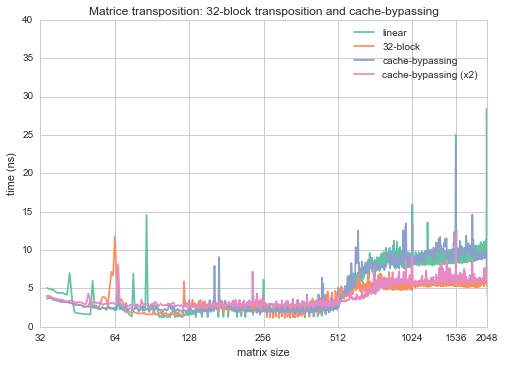

In [41]:
plt.plot(interval_fast[32:], times_fast[32:], label="linear")
plt.plot(interval_32[32:], times_32[32:], label="32-block")
plt.plot(interval_bypass[32:], times_bypass[32:], label="cache-bypassing")
plt.plot(interval_bypass2[32:], times_bypass2[32:], label="cache-bypassing (x2)")
plt.legend(loc="best")

add_info("Matrice transposition: 32-block transposition and cache-bypassing")

A priori, l'écriture directe n'apporte pas grand chose sur le calcul de la transposition, mais si on écrit deux lignes à la fois, alors on retrouve les performances de la transposée par blocs. On peut alors pousser l'étude pour des matrices plus grandes :

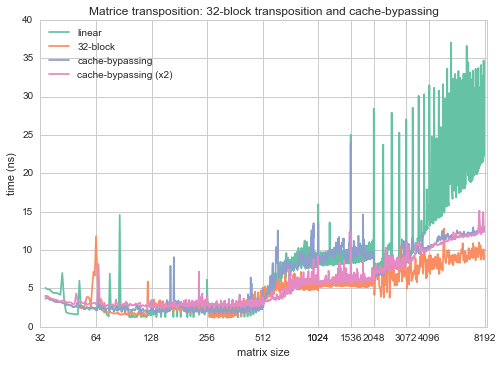

In [42]:
plt.plot(interval_fast[32:], times_fast[32:], label="linear")
plt.plot(interval_32[32:], times_32[32:], label="32-block")
plt.plot(interval_bypass[32:], times_bypass[32:], label="cache-bypassing")
plt.plot(interval_bypass2[32:], times_bypass2[32:], label="cache-bypassing (x2)")
plt.legend(loc="best")

add_info("Matrice transposition: 32-block transposition and cache-bypassing",
         xlim=(32, 8400),
         ticks=[5, 6, 7, 8, 9, 10, 9 + np.log2(3), 10, 11, 10 + np.log2(3), 12, 13])

Passé le seuil des 2048 × 2048, les deux stratégies d'évitement du cache (en écriture) se rejoignent pour rester moins performantes que la transposition par blocs bien que meilleures que la méthode classique et sans chute de performances sur les combinaisons linéaires de puissances de deux.

## Bibliographie

Les références incontournables, à recommander les yeux fermés :
- [Computer Architecture, A Quantitative Approach](http://www.amazon.com/dp/012383872X), by Hennessy & Patterson (2007, 2011)
- [What Every Programmer Should Know About Memory](https://duckduckgo.com/?q=what+every+programmer+should+know+about+memory&t=ffab), by Ulrich Drepper (2007)
- [Optimizing software in C++](http://www.agner.org/optimize/optimizing_cpp.pdf), by Agner Fog (2004 -- 2015)
- Materials for a [Computer Architecture class](https://www.cs.tcd.ie/Jeremy.Jones/CS3021/CS3021.htm), by Jeremy Jones

Sur un sujet connexe :
- [Achieving maximum memory bandwidth](http://codearcana.com/posts/2013/05/18/achieving-maximum-memory-bandwidth), by Alex Reece (2013).
